In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import glob
import dask
import matplotlib
import scipy.special as sps  
import xagg as xa
import pickle

In [4]:
from dask.distributed import Client
client = Client(n_workers=8)
client

distributed.diskutils - INFO - Found stale lock file and directory '/glade/work/elkoukah/empirical/production/analysis/dask-worker-space/worker-3_3lnong', purging


<Client: 'tcp://127.0.0.1:34063' processes=8 threads=256, memory=235.00 GiB>

# Preprocess

In [2]:
def get_obs(indir_obs, inf_qobs, inf_stattrs, tdelta):
    """
    Return stations obs dataset,
    """
    df = pd.read_csv(indir_obs+inf_qobs)
    st_ids = df.iloc[0, 1:].values
    df0 = df.iloc[5:-5]
    df0.columns = ['date']+st_ids.tolist()
    index = pd.to_datetime(df0.date)
    df0.loc[:, 'date'] = index
    df0.rename(columns={'date':'time'}, inplace=True)
    df0.set_index('time', inplace=True)
    df1 = df0.astype('float')
    df_sts = pd.read_csv(indir_obs+inf_stattrs,
                         dtype={'stid':str, 'lon':float, 'lat':float})
    st_ids_eval = df_sts['stid']
    df1_sts = df1.loc[tdelta, st_ids_eval]
    month_length = df1_sts.index.days_in_month.values
    df1_sts = df1_sts/(70.07*month_length[:, np.newaxis]) # m3/s
    qobs = df1_sts.to_xarray()
    df_sts.set_index('stid', inplace=True)
    return qobs, st_ids_eval, df_sts

def read_camels(camels_dir_qobs, camels_coord_file, camels_swus_gaugeid):
    df0 = pd.read_csv(camels_coord_file, delimiter=';', index_col=0)
    df_gid = pd.read_csv(camels_swus_gaugeid)
    df1 = df0.loc[df_gid['gauge_id']]

    huc = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18']
    sel_gauges = df1.index.tolist()
    camels_qobs_files = []
    for i in huc:
        files = os.listdir(camels_dir_qobs+i+'/')
        filespath = [camels_dir_qobs+i+'/'+f for f in files if (int(f.split('_')[0]) in sel_gauges)] 
        camels_qobs_files.extend(filespath)

    dfs_list = []
    for fpath in camels_qobs_files:
        gid = os.path.basename(fpath).split('_')[0]
        df0_obs = pd.read_csv(fpath, sep='\s+', names=['gauge_id', 'year', 'month', 'day', int(gid), 'flag'])
        df0_obs['time'] = pd.to_datetime(df0_obs[['year','month','day']])
        df0_obs = df0_obs.set_index('time')
        df0_obs = df0_obs.drop(['gauge_id', 'year','month','day','flag'], axis=1)
        dfs_list.append(df0_obs)

    df_obs = pd.concat(dfs_list, axis=1)
    ds_obs = df_obs.to_xarray()
    return ds_obs.where(ds_obs>=0)

import scipy.special as sps  

def ds_aave_polygon(ds,gdf):
    weightmap = xa.pixel_overlaps(ds,gdf)
    aggregated = xa.aggregate(ds, weightmap)
    ds_aave = aggregated.to_dataset()
    return ds_aave
    
def route(da, shape=2.5, scale=1):
    nt = da.time.size
    t = np.arange(0, nt)
    y = t**(shape-1)*(np.exp(-t/scale) /  
                         (sps.gamma(shape)*scale**shape))
    q = np.convolve(y, da.data[:-1], mode='full')
    q = xr.DataArray(q[:nt-1], dims=('time',), coords={'time':da.time[:nt-1]}, name='Q')
    return q

import xagg as xa
def calc_discharge(casename, roffile, camels_stations, gdf_camels, reclamation_comid_idx, reclamation_stations):
    archive_dir = '/glade/derecho/scratch/elkoukah/archive/'
    print('\n processing:', casename)
    hdir = archive_dir+casename+'/lnd/hist'
    dsh = xr.open_dataset(hdir+'/'+roffile).load()
    print(dsh)
    res = 0.04
    
    # Discharge at Camels
    dict_q = {}
    for basin in camels_stations:
        
        print('area averaging:', basin)
        gdfi = gdf_camels.loc[int(basin)]
        geom = gpd.GeoDataFrame({'tag': [basin], 'geometry': [gdfi.geometry]}, crs="EPSG:4326")
        minx,miny,maxx,maxy = geom.bounds.values[0]
        minx,miny,maxx,maxy = minx-res,miny-res,maxx+res,maxy+res
        # dsh_bounds = dsh.sel(lat=slice(miny,maxy), lon=slice(minx,maxx)).compute()
        dsh_bounds = dsh.sel(lat=slice(miny,maxy), lon=slice(minx+360,maxx+360))
        dsh_aave = ds_aave_polygon(dsh_bounds[['QRUNOFF']], geom)
        
        print('routing runoff:', basin)
        rof = dsh_aave['QRUNOFF'][0]*24*60**2
        discharge = route(rof)
        A = df_attrs_camels.loc[int(basin),'area_gages2']*10**6
        fc = (10**-3)*A/(24*60**2)
        dict_q[basin] = discharge*fc

    # Discharge at reclamation
    def get_ensemble_member(ds, comid_idx=reclamation_comid_idx):
        ds_seg = ds.sel(seg=comid_idx)
        return ds_seg['KWTroutedRunoff']
    rofdir = archive_dir+casename+'/rof/hist'
    print(rofdir)
    dsq = xr.open_mfdataset(rofdir+'/*.h.*.nc', preprocess=get_ensemble_member)
    dsq = dsq.assign_coords({'seg':reclamation_stations}).compute()
    for basin in reclamation_stations:
        q = dsq['KWTroutedRunoff'].sel(seg=basin)
        dict_q[basin] = q.drop_vars('seg')
    ds_q = xr.Dataset(dict_q)
    return ds_q

def calc_mkge(x,y):
    r2 = np.mean((y.T-y.mean()).T*(x-x.mean()))/(y.std()*x.std())
    beta = (y.mean()-x.mean())/x.std()
    sigma = y.std()/x.std()
    mkge = 1 - np.sqrt(((r2-1)**2 + (sigma-1)**2 + beta**2))
    bias = (y.mean()/x.mean() - 1)*100
    return mkge, r2, beta, sigma, bias

def calc_nse(x,y):
    nse = 1 - np.sum((y-x)**2)/np.sum((x-x.mean())**2)
    return nse

## CR

### Discharge

In [3]:
# Discharge observations

## Reclamation
indir_obs = '/glade/work/elkoukah/inputs/obs/'
inf_qobs = 'NaturalFlows1906-2020_20221215.csv'
inf_stattrs = 'cr_station_attrs_wgs84.csv'
mdl_varname = 'outflw'
dt = '1M'
tdelta = slice("1912-10-01", "2021-09-30")
qobs, stn_eval, df_sts = get_obs(indir_obs, inf_qobs, inf_stattrs, tdelta)

## CAMELS
camels_coord_file = '/glade/work/elkoukah/inputs/obs/CAMELS/camels_topo.txt'
camels_swus_gaugeid = '/glade/work/elkoukah/inputs/obs/CAMELS/camels_swus_gaugeid.txt'
camels_dir_qobs = '/glade/work/elkoukah/inputs/obs/CAMELS/usgs_streamflow/'
ds_obs_camels = read_camels(camels_dir_qobs, camels_coord_file, camels_swus_gaugeid)

/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [5]:
# Discharge simulations comids

## Reclamation Stations ids
comids_crb = pd.read_csv('/glade/work/elkoukah/inputs/obs/crb_stations_comid.csv')
reclamation_stations = comids_crb['stid'].values
ds_topology = xr.open_dataset('/glade/work/elkoukah/empirical/production/mizuroute//ancillary_data/topology_77032202.nc')
comid_idx = []
for comid in comids_crb['COMID']:
    idx = (ds_topology['segId']==comid).argmax().data
    comid_idx.append(idx)
comid_idx = np.stack(comid_idx)

## CAMELs station ids and basins
camels_crb = pd.read_csv('/glade/work/elkoukah/inputs/obs/camels_crb_gauges.csv')
camels_stations = camels_crb['GAGE_ID'].values
gdf_camels = gpd.read_file('/glade/work/elkoukah/inputs/obs/CAMELS/HCDN_nhru_final_671.shp')
gdf_camels = gdf_camels.set_index('hru_id')
camels_coord_file = '/glade/work/elkoukah/inputs/obs/CAMELS/camels_topo.txt'
df_attrs_camels = pd.read_csv(camels_coord_file, delimiter=';', index_col=0)

In [7]:
# streamflow at stations
flag_calc = False
if flag_calc:
    casename = 'CR_conus404_asmo_newsurfdata_fanrootingdepth.002'
    casename = 'CR_conus404_newsurfdata_default.002'
    roffile = 'QRUNOFF.nc'
    ds_qmdl = calc_discharge(casename, roffile, camels_stations, gdf_camels, comid_idx, reclamation_stations)
    for var in ds_qmdl.data_vars:
        ds_qmdl = ds_qmdl.rename({var:str(var)})
    ofile = '/glade/derecho/scratch/elkoukah/pipeline/%s_discharge_camels_reclamation.nc'%casename
    ds_qmdl.to_netcdf(ofile)

In [211]:
# Calculate metrics

In [ ]:
casename = 'CR_conus404_asmo_newsurfdata_fanrootingdepth.002'
# casename = 'CR_conus404_newsurfdata_default.002'

ofile = '/glade/derecho/scratch/elkoukah/pipeline/%s_discharge_camels_reclamation.nc'%casename
ds_qmdl_opt = xr.open_dataset(ofile)

tdelta = slice('1980-10-01','2020-09-30')

qobs_camels_t = ds_obs_camels.sel(time=tdelta)
t = qobs_camels_t.time
qobs_camels_t = qobs_camels_t.sel(time=(t.dt.month!=2)+(t.dt.day!=29))
qobs_reclamation_t = qobs.sel(time=tdelta)

qmdl_t = ds_qmdl_opt.sel(time=tdelta)
qmdl_t['time'] = qmdl_t.time.astype('datetime64[ns]')

q_metrics = ['mkge', 'r2', 'beta', 'sigma', 'pbias', 'nse', 'nse_wy', 'qsim_mean']
print('calculate streamflow metrics:', q_metrics)
nmetric = len(q_metrics)
stations = np.hstack([camels_stations, reclamation_stations])
nstations = stations.size
df_q_metrics = pd.DataFrame(np.full((nmetric, nstations), np.nan), index=q_metrics, columns=stations)

for station in camels_stations:#[ma_camels]:
    yy = qmdl_t[str(station)]
    xx = qobs_camels_t[station]*0.02832 #from cf/s to m3/s
    
    yy = yy.sel(time=xx.time)
    ma = xx.isnull().data
    yy = yy[~ma]
    xx = xx[~ma]
    xxm = xx.resample(time='1M').mean().data
    yym = yy.resample(time='1M').mean().data
    mkge, r2, beta, sigma, bias = calc_mkge(xxm,yym)
    nse = calc_nse(xxm,yym)
    nse_wy = calc_nse(xx.resample(time='A-SEP').mean().data,
                      yy.resample(time='A-SEP').mean().data)
    qsim_mean = yy.mean().data
    df_q_metrics.loc[:, station] = [mkge, r2, beta, sigma, bias, nse, nse_wy, qsim_mean]
for station in reclamation_stations:#[ma_reclamation]:
    yy = qmdl_t[str(station)]
    xx = qobs_reclamation_t['0%i'%station]
    
    yym = yy.resample(time='1M').mean().data
    xxm = xx.data
    mkge, r2, beta, sigma, bias = calc_mkge(xxm,yym)
    nse = calc_nse(xxm,yym)
    nse_wy = calc_nse(xx.resample(time='A-SEP').mean().data,
                      yy.resample(time='A-SEP').mean().data)
    qsim_mean = yy.mean().data
    df_q_metrics.loc[:, station] = [mkge, r2, beta, sigma, bias, nse, nse_wy, qsim_mean]
ofile = '/glade/derecho/scratch/elkoukah/pipeline/%s_discharge_metrics_%s-%s.csv'%(casename, tdelta.start[:4], tdelta.stop[:4])
print(ofile)
df_q_metrics.T.to_csv(ofile)

In [177]:
comids_crb = pd.read_csv('/glade/work/elkoukah/inputs/obs/crb_stations_comid.csv', index_col='stid')
reclamation_stations = comids_crb.index.values
camels_crb = pd.read_csv('/glade/work/elkoukah/inputs/obs/camels_crb_gauges.csv', index_col='GAGE_ID')
camels_stations = camels_crb.index.values
stations = np.hstack([camels_stations,reclamation_stations])
stations_coords = pd.DataFrame(np.zeros((stations.size, 2)), index=stations, columns=('lat','lon'))
stations_coords.loc[camels_stations] = camels_crb[['LAT','LONG']].loc[camels_stations].values
stations_coords.loc[reclamation_stations] = comids_crb[['lat','lon']].loc[reclamation_stations].values

casename = 'CR_conus404_asmo_newsurfdata_fanrootingdepth.002'
ifile = '/glade/derecho/scratch/elkoukah/pipeline/%s_discharge_metrics_1980-2020.csv'%casename
df_metrics = pd.read_csv(ifile, index_col=0)
df_metrics.loc[stations, ['lat','lon']] = stations_coords.values
df_metrics.to_csv('./out/metrics_opt_cr_101980-092020.csv')

casename = 'CR_conus404_newsurfdata_default.002'
ifile = '/glade/derecho/scratch/elkoukah/pipeline/%s_discharge_metrics_1980-2019.csv'%casename
df_metrics = pd.read_csv(ifile, index_col=0)
df_metrics.loc[stations, ['lat','lon']] = stations_coords.values
df_metrics.to_csv('./out/metrics_base_cr_101980-092019.csv')

### Sensitivity to climate

In [217]:
def calc_streamflow_sensitivity(ppt, temp, q):
    P = ppt.resample(time='A-SEP').mean()
    T = temp.resample(time='A-SEP').mean()
    Q = q.resample(time='A-SEP').mean()

    Panom = (P-P.mean())/P.mean() * 100
    Tanom = (T-T.mean())
    Qanom = (Q-Q.mean())/Q.mean() * 100

    X = np.stack([Panom.data[:],
                  Tanom.data[:],
                  np.ones((Panom.size))
                 ])
    Y = Qanom.data[:]
    # reg = linear_model.LinearRegression()
    # reg.fit(X.T, Y)
    # a, b, s = reg.coef_
    a, b, s = np.linalg.lstsq(X.T, Y)[0]
    return a, b

def calc_nse(x,y):
    nse = 1 - np.sum((y-x)**2)/np.sum((x-x.mean())**2)
    return nse

In [218]:
from shapely.geometry import Polygon

In [219]:
def gen_polygon_mask(lats, lons, res, geom):
    gridcells = [Polygon(((x-res, y-res), 
                      (x-res, y+res), 
                      (x+res, y+res), 
                      (x+res,y-res), 
                      (x-res, y-res))) for x,y in zip(lons, lats)]
    ngrd = len(gridcells)
    mask = np.zeros((ngrd,), dtype=int)
    for ii in range(ngrd):
        mask[ii] = geom.intersects(gridcells[ii])
    return mask

In [220]:
import pickle

In [221]:
# inputs
qens = xr.open_dataset('/glade/derecho/scratch/elkoukah/pipeline/optz-top37_ucrb-0.9x1.25_0.base_daily_discharge_9380000_2.nc')
livneh_dict = pickle.load(open('/glade/derecho/scratch/elkoukah/inputs/livneh/ucrb.pkl', 'rb'))
dict_prism = pickle.load(open('/glade/derecho/scratch/elkoukah/inputs/prism/postprocess/prism_ucrb.pkl', 'rb'))
qobs = xr.open_dataset('/glade/work/elkoukah/inputs/obs/crb_reclamation_natflow.nc')
prism_ppt, prism_temp = dict_prism['prism_ppt'], dict_prism['prism_temp']

In [222]:
shapfile = '/glade/work/elkoukah/inputs/domain/shapefile/ucrb_epsg4326.shp'
gdf = gpd.read_file(shapfile)
bounds = gdf.bounds.iloc[0]
geom = gdf.geometry

In [223]:
# Model forcings

In [224]:
archive_dir = '/glade/derecho/scratch/elkoukah/archive/'
casename = 'CR_conus404_asmo_newsurfdata_fanrootingdepth.002'
files = sorted(glob.glob(archive_dir+casename+'/lnd/hist/'+casename+'.clm2.h0.*.nc'))
data_vars = ['RAIN', 'SNOW', 'TBOT']
def preprocess(ds):
    return ds[data_vars]
h0 = xr.open_mfdataset(files, parallel=True, preprocess=preprocess)

In [225]:
h0['lon'] = h0.lon-360

In [226]:
h0_bbox = h0.sel(lat=slice(bounds['miny'], bounds['maxy']), 
                 lon=slice(bounds['minx'], bounds['maxx']))

In [227]:
lons, lats = np.meshgrid(h0_bbox.lon, h0_bbox.lat)
mask = gen_polygon_mask(lats.ravel(), lons.ravel(), 0.02, geom)
mask = xr.DataArray(mask.reshape(lats.shape), dims=(('lat','lon')), name='mask')

In [228]:
rain_mdl = h0_bbox['RAIN'].where(mask>0).mean(('lon','lat')).compute()
snow_mdl = h0_bbox['SNOW'].where(mask>0).mean(('lon','lat')).compute()
tbot_mdl = h0_bbox['TBOT'].where(mask>0).mean(('lon','lat')).compute()

In [229]:
ppt = (rain_mdl+snow_mdl)*24*60**2

In [230]:
## Reclamation Stations ids
comids_crb = pd.read_csv('/glade/work/elkoukah/inputs/obs/crb_stations_comid.csv')
ds_topology = xr.open_dataset('/glade/work/elkoukah/empirical/production/mizuroute//ancillary_data/topology_77032202.nc')
comid = comids_crb[comids_crb['stid']==9380000].COMID.values # upper basin outlet comid
comid_idx = (ds_topology['segId']==comid).argmax().data
def get_ensemble_member(ds, comid_idx=comid_idx):
    ds_seg = ds.sel(seg=comid_idx)
    return ds_seg['KWTroutedRunoff']
archive_dir = '/glade/derecho/scratch/elkoukah/archive/'
casename = 'CR_conus404_asmo_newsurfdata_fanrootingdepth.002'
rofdir = archive_dir+casename+'/rof/hist/'
ifiles = sorted(glob.glob(rofdir+'/*.h.*nc'))
ds_qopt = xr.open_mfdataset(ifiles, parallel=True, preprocess=get_ensemble_member)

In [231]:
comids_crb = pd.read_csv('/glade/work/elkoukah/inputs/obs/crb_stations_comid.csv')
ds_topology = xr.open_dataset('/glade/work/elkoukah/empirical/production/mizuroute/ancillary_data/topology_77020591.nc')
comid = comids_crb[comids_crb['stid']==9380000].COMID.values # upper basin outlet comid
comid_idx = (ds_topology['segId']==comid).argmax().data
def get_ensemble_member(ds, comid_idx=comid_idx):
    ds_seg = ds.sel(seg=comid_idx)
    return ds_seg['KWTroutedRunoff']
archive_dir = '/glade/derecho/scratch/elkoukah/archive/'
casename = '14_conus404_reference.base_001'
rofdir = archive_dir+casename+'/rof/hist/'
ifiles = sorted(glob.glob(rofdir+'/*.h.*nc'))
ds_qbase = xr.open_mfdataset(ifiles, parallel=True, preprocess=get_ensemble_member)

In [232]:
# Metrics
tdelta = slice('1981-10-01', '2019-09-30')
A = 293569*10**6 #m2

# observed estimates
ppt_obs = prism_ppt.sel(time=tdelta)
temp_obs = prism_temp.sel(time=tdelta)
q_obs = qobs['09380000'].sel(time=tdelta)
alpha_obs, beta_obs = calc_streamflow_sensitivity(ppt_obs, temp_obs, q_obs)
month_length = ppt_obs.time.dt.days_in_month
pbar = (ppt_obs/(month_length*24*60**2)).mean()
rratio_obs = q_obs.mean()/(pbar*A*10**-3)
print(alpha_obs, beta_obs)

1.4437052055779256 -5.443627561846899


/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [233]:
# model estimates
ppt_mdl = ppt.sel(time=tdelta)
temp_mdl = tbot_mdl.sel(time=tdelta)
q_mdl = ds_qopt['KWTroutedRunoff'].sel(time=tdelta).compute()
alpha_mdl, beta_mdl = calc_streamflow_sensitivity(ppt_mdl, temp_mdl, q_mdl)
print(alpha_mdl, beta_mdl)

1.8069337596943411 -1.443119462401359


/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [234]:
# model estimates
ppt_mdl = ppt.sel(time=tdelta)
temp_mdl = tbot_mdl.sel(time=tdelta)
q_mdl_base = ds_qbase['KWTroutedRunoff'].sel(time=tdelta).compute()
alpha_mdl, beta_mdl = calc_streamflow_sensitivity(ppt_mdl, temp_mdl, q_mdl_base)
print(alpha_mdl, beta_mdl)

1.1629606477417125 9.486081783559051


/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [235]:
pbar = ppt_mdl*A*10**-3
rratio_obs = q_obs.mean()/(pbar*A*10**-3)

In [237]:
yy = q_mdl.resample(time='A-SEP').mean()
yy0 = q_mdl_base.resample(time='A-SEP').mean()
kk = q_obs.resample(time='A-SEP').mean()
xx = ppt_mdl.resample(time='A-SEP').mean()
xx0 = ppt_obs.resample(time='A-SEP').mean()

dyy = (yy-yy.mean())/yy.mean() * 100
dyy0 = (yy0-yy0.mean())/yy0.mean() * 100
dkk = (kk-kk.mean())/kk.mean() * 100
dxx = (xx-xx.mean())/xx.mean() * 100
dxx0 = (xx0-xx0.mean())/xx0.mean() * 100

In [240]:
dict_sens_cr = {'q_mdl':q_mdl, 'q_mdl_base':q_mdl_base, 'q_obs':q_obs, 'ppt_mdl':ppt_mdl, 'ppt_obs':ppt_obs,
             'dyy':dyy, 'dyy0':dyy0, 'dkk':dkk, 'dxx':dxx, 'dxx0':dxx0}
pickle.dump(dict_sens_cr, open('dict_sens_cr.pkl', 'wb'))

In [241]:
slope_mdl0, _ = np.linalg.lstsq(np.stack([dxx.data,np.ones(dxx.size)]).T, dyy0)[0]
slope_mdl, _ = np.linalg.lstsq(np.stack([dxx.data,np.ones(dxx.size)]).T, dyy)[0]
slope_obs, _ = np.linalg.lstsq(np.stack([dxx0.data,np.ones(dxx0.size)]).T, dkk)[0]
print(slope_mdl0, slope_mdl, slope_obs, (slope_mdl0-slope_obs)/slope_obs, (slope_mdl-slope_obs)/slope_obs)

0.9976963823169513 1.8320754444611005 1.5647443265441432 -0.3623901583203438 0.17084651682832963


/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.
/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  
/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M a

## CA

### Discharge

In [54]:
import scipy.special as sps  
import xagg as xa

def ds_aave_polygon(ds,gdf):
    weightmap = xa.pixel_overlaps(ds,gdf)
    aggregated = xa.aggregate(ds, weightmap)
    ds_aave = aggregated.to_dataset()
    return ds_aave
def route(da, shape=2.5, scale=1):
    nt = da.time.size
    t = np.arange(0, nt)
    y = t**(shape-1)*(np.exp(-t/scale) /  
                         (sps.gamma(shape)*scale**shape))
    q = np.convolve(y, da.data[:-1], mode='full')
    q = xr.DataArray(q[:nt-1], dims=('time',), coords={'time':da.time[:nt-1]}, name='Q')
    return q

def calc_discharge_ca(casename, roffile, camels_stations, ingdf, comid_idx_ca, cdec_stations):
    archive_dir = '/glade/derecho/scratch/elkoukah/archive/'
    print('\n processing:', casename)
    hdir = archive_dir+casename+'/lnd/hist'
    dsh = xr.open_dataset(hdir+'/'+roffile).load()
    print(dsh)
    res = 0.04
    # Discharge at Camels
    dict_q = {}
    for basin in camels_stations:
        print('area averaging:', basin)
        gdfi = ingdf.loc[int(basin)]
        geom = gpd.GeoDataFrame({'tag': [basin], 'geometry': [gdfi.geometry]}, crs="EPSG:4326")
        minx,miny,maxx,maxy = geom.bounds.values[0]
        minx,miny,maxx,maxy = minx-res,miny-res,maxx+res,maxy+res
        dsh_bounds = dsh.sel(lat=slice(miny,maxy), lon=slice(minx+360,maxx+360))
        dsh_aave = ds_aave_polygon(dsh_bounds[['QRUNOFF']], geom)
        
        print('\nrouting runoff:', basin)
        rof = dsh_aave['QRUNOFF'][0]*24*60**2
        discharge = route(rof)
        A = df_attrs_camels.loc[int(basin),'area_gages2']*10**6
        fc = (10**-3)*A/(24*60**2)
        dict_q[str(basin)] = discharge*fc
    
    # Discharge at reclamation
    print('\nreading discharge:')
    def get_ensemble_member(ds, comid_idx=comid_idx_ca):
        ds_seg = ds.sel(seg=comid_idx)
        return ds_seg['KWTroutedRunoff']
    rofdir = archive_dir+casename+'/rof/hist'
    dsq = xr.open_mfdataset(rofdir+'/*.h.*.nc', preprocess=get_ensemble_member)
    dsq = dsq.assign_coords({'seg':cdec_stations}).compute()
    for basin in cdec_stations:
        q = dsq['KWTroutedRunoff'].sel(seg=basin)
        dict_q[basin] = q.drop_vars('seg')
    ds_q = xr.Dataset(dict_q)
    return ds_q

def calc_mkge(x,y):
    r2 = np.mean((y.T-y.mean()).T*(x-x.mean()))/(y.std()*x.std())
    beta = (y.mean()-x.mean())/x.std()
    sigma = y.std()/x.std()
    mkge = 1 - np.sqrt(((r2-1)**2 + (sigma-1)**2 + beta**2))
    bias = (y.mean()/x.mean() - 1)*100
    return mkge, r2, beta, sigma, bias

def calc_nse(x,y):
    nse = 1 - np.sum((y-x)**2)/np.sum((x-x.mean())**2)
    return nse

def read_camels(camels_dir_qobs, camels_coord_file, gauge_ids):
    df0 = pd.read_csv(camels_coord_file, delimiter=';', index_col=0)
    df1 = df0.loc[gauge_ids]

    huc = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18']
    sel_gauges = df1.index.tolist()
    camels_qobs_files = []
    for i in huc:
        files = os.listdir(camels_dir_qobs+i+'/')
        filespath = [camels_dir_qobs+i+'/'+f for f in files if (int(f.split('_')[0]) in sel_gauges)] 
        camels_qobs_files.extend(filespath)

    dfs_list = []
    for fpath in camels_qobs_files:
        gid = os.path.basename(fpath).split('_')[0]
        df0_obs = pd.read_csv(fpath, sep='\s+', names=['gauge_id', 'year', 'month', 'day', int(gid), 'flag'])
        df0_obs['time'] = pd.to_datetime(df0_obs[['year','month','day']])
        df0_obs = df0_obs.set_index('time')
        df0_obs = df0_obs.drop(['gauge_id', 'year','month','day','flag'], axis=1)
        df0_obs = df0_obs.rename(columns={df0_obs.columns[0]:str(df0_obs.columns[0])})
        dfs_list.append(df0_obs)
        

    df_obs = pd.concat(dfs_list, axis=1)
    ds_obs = df_obs.to_xarray()
    return ds_obs.where(ds_obs>=0)


def calc_metrics(qmdl, qobs, stations_id, tdelta):
    cols = ['mkge', 'r2', 'beta', 'alpha', 'pbias', 'nse', 'qsim_mean']
    df_metrics = pd.DataFrame(np.full((len(stations_id), len(cols)), np.nan), 
                     columns=cols, index=stations_id)
    for st in stations_id:
        yy = qmdl[st].sel(time=tdelta).resample(time='1M').mean()
        xx = qobs[st].sel(time=tdelta).resample(time='1M').mean()
        ma = xx.isnull()
        r = ma.sum()/yy.size
        if r>.7:
            print('skip', st, '%.2f'%r)
            continue
        else:
            xx = xx[~ma.data]
            yy = yy[~ma.data]
        mkge, r2, beta, sigma, bias = calc_mkge(xx.data, yy.data)
        nse = calc_nse(xx.data, yy.data)
        qsim_mean = yy.mean().data
        df_metrics.loc[st] = [mkge, r2, beta, sigma, bias, nse, qsim_mean]
    return df_metrics

In [41]:
# Simulations

In [48]:
ds_topology = xr.open_dataset('/glade/work/elkoukah/empirical/optimize/opt_camels/routing/ancillary_data/topology_CA.nc')
comids_ca = pd.read_csv('/glade/work/elkoukah/inputs/obs/CDEC_Stations_COMID.csv')
comids_ca = comids_ca.set_index('STA')
comids_ca = comids_ca.drop('CLD')
cdec_stations = comids_ca.index.values
comid_idx = []
for comid in comids_ca['COMID']:
    idx = (ds_topology['segId']==comid).argmax().data
    comid_idx.append(idx)
comid_idx_ca = np.stack(comid_idx)

camels_comid_sw = pd.read_csv('/glade/work/elkoukah/inputs/obs/camels_swus_gauge_comid.csv')
camels_comid_ca = camels_comid_sw[camels_comid_sw['HUC_02']==18]
camels_stations_ca = camels_comid_ca['GAGE_ID'].values

gdf_camels = gpd.read_file('/glade/work/elkoukah/inputs/obs/CAMELS/HCDN_nhru_final_671.shp')
gdf_camels = gdf_camels.set_index('hru_id')
gdf_camels_ca = gdf_camels.loc[camels_comid_ca['GAGE_ID']]

camels_coord_file = '/glade/work/elkoukah/inputs/obs/CAMELS/camels_topo.txt'
df_attrs_camels = pd.read_csv(camels_coord_file, delimiter=';', index_col=0)

In [49]:
flag_calc = False
if flag_calc:
    casename = 'CA_conus404_asmo_newsurfdata_default.001'
    qbase = calc_discharge_ca(casename, 'QRUNOFF.nc', camels_stations_ca, gdf_camels_ca, comid_idx_ca, cdec_stations)
    
    casename = 'CA_conus404_newsurfdata_asmo.opt_002'
    qopt = calc_discharge_ca(casename, 'QRUNOFF.nc', camels_stations_ca, gdf_camels_ca, comid_idx_ca, cdec_stations)
    
    casename = 'CA_conus404_asmo_newsurfdata_default.001'
    ofile = '/glade/derecho/scratch/elkoukah/pipeline/%s_discharge_camels_reclamation.nc'%casename
    qbase.to_netcdf(ofile)
    
    casename = 'CA_conus404_newsurfdata_asmo.opt_002'
    ofile = '/glade/derecho/scratch/elkoukah/pipeline/%s_discharge_camels_reclamation.nc'%casename
    qopt.to_netcdf(ofile)

In [50]:
casename = 'CA_conus404_asmo_newsurfdata_default.001'
ofile = '/glade/derecho/scratch/elkoukah/pipeline/%s_discharge_camels_reclamation.nc'%casename
qbase = xr.open_dataset(ofile)

casename = 'CA_conus404_newsurfdata_asmo.opt_002'
ofile = '/glade/derecho/scratch/elkoukah/pipeline/%s_discharge_camels_reclamation.nc'%casename
qopt = xr.open_dataset(ofile)

In [51]:
# Observations
# indir_ca = '/glade/work/elkoukah/inputs/obs/ca_natflw/'
# st_atts = '/glade/work/elkoukah/inputs/obs/CDEC_Stations.csv'
# df_sts = pd.read_csv(st_atts)
# instids = ['AMA', 'AMF', 'AMK', 'AMN', 'ANM', 'ANT', 'ASP', 'ASS', 'ASV', 'BHN', 'CSN', 'CYO', 'DAV', 'EFC', 'ERS',
#            'EWR', 'FPL', 'FPR', 'FRD', 'FTC', 'FTM', 'FTO', 'FTP', 'KGC', 'KGF', 'KGP', 'KLO', 'KRB', 'KRI', 
#            'KRK', 'KWT', 'MBS', 'MDP', 'MKM', 'MKW', 'MRC', 'MSS', 'NCD', 'NPH', 'OTR', 'OWL', 'PLK', 'PSH', 
#            'RRH', 'SBB', 'SCC', 'SCU', 'SDT', 'SFJ', 'SFR', 'SIS', 'SJF', 'SJM', 'SJU', 'SMU', 'SNS', 'SQS', 'SRS', 
#            'SSP', 'STB', 'SVC', 'SWH', 'TLG', 'TLM', 'TLN', 'TLU', 'TNL', 'TRF', 'WFC', 'WWR', 'YBG', 'YBJ', 'YBM', 'YBS', 'YCB', 'YRS']
# dict_sts = {}
# for stid in instids:
#     df = pd.read_csv(indir_ca+stid+'.csv')
#     index = pd.to_datetime(df['DATE TIME'])
#     df['time'] = index
#     df1 = df.set_index('time')
#     df1[stid] = df1['VALUE']
#     df1[stid][(df1[stid] == '---')] = np.nan
#     df2 = df1[stid].astype('float')
#     month_length = df2.index.days_in_month.values
#     df2 = df2/(70.07*month_length)
#     dict_sts[stid] = df2.to_xarray()
# ds_ca = xr.Dataset(dict_sts)
# ds_ca.to_netcdf('/glade/work/elkoukah/inputs/obs/ca_qnat_full.nc')

In [55]:
# CDEC
qca = xr.open_dataset('/glade/work/elkoukah/inputs/obs/ca_qnat_full.nc')

# CAMELS
camels_coord_file = '/glade/work/elkoukah/inputs/obs/CAMELS/camels_topo.txt'
camels_swus_gaugeid = '/glade/work/elkoukah/inputs/obs/CAMELS/camels_swus_gaugeid.txt'
camels_dir_qobs = '/glade/work/elkoukah/inputs/obs/CAMELS/usgs_streamflow/'
qobs_camels_ca = read_camels(camels_dir_qobs, camels_coord_file, camels_stations_ca)

station_ids = cdec_stations.tolist()+camels_stations_ca.astype('str').tolist()
qobs = xr.merge([qca, qobs_camels_ca])

tdelta = slice('1980-10-01', '2020-09-30')
df_metrics_base = calc_metrics(qbase, qobs, station_ids, tdelta)
df_metrics_base = df_metrics_base.dropna(axis=0)

df_metrics_opt = calc_metrics(qopt, qobs, station_ids, tdelta)
df_metrics_opt = df_metrics_opt.dropna(axis=0)

skip AMA 0.74
skip AMK 0.72
skip BHN 1.00
skip FTC 0.73
skip FTM 1.00
skip FTP 0.70
skip KGP 0.72
skip MKW 0.95
skip OTR 1.00
skip PLK 0.74
skip SFJ 1.00
skip SFR 1.00
skip SJM 1.00
skip SJU 1.00
skip SMU 1.00
skip SQS 0.84
skip TLM 0.70
skip TLU 1.00
skip YBM 0.72
skip AMA 0.74
skip AMK 0.72
skip BHN 1.00
skip FTC 0.73
skip FTM 1.00
skip FTP 0.70
skip KGP 0.72
skip MKW 0.95
skip OTR 1.00
skip PLK 0.74
skip SFJ 1.00
skip SFR 1.00
skip SJM 1.00
skip SJU 1.00
skip SMU 1.00
skip SQS 0.84
skip TLM 0.70
skip TLU 1.00
skip YBM 0.72


In [65]:
df_metrics_base.loc[df_metrics_base.index[:57], 'lat'] = comids_ca.loc[df_metrics_base.index[:57], 'Latitude']
df_metrics_base.loc[df_metrics_base.index[:57], 'lon'] = comids_ca.loc[df_metrics_base.index[:57], 'Longitude']
df_metrics_opt.loc[df_metrics_base.index[:57], 'lat'] = comids_ca.loc[df_metrics_base.index[:57], 'Latitude']
df_metrics_opt.loc[df_metrics_base.index[:57], 'lon'] = comids_ca.loc[df_metrics_base.index[:57], 'Longitude']

In [67]:
df_metrics_base.to_csv('./out/metrics_base_ca_camels_101980-092020.csv')
df_metrics_opt.to_csv('./out/metrics_opt_ca_camels_101980-092020.csv')

### Sensitivity to climate

In [242]:
def calc_streamflow_sensitivity(ppt, temp, q):
    P = ppt.resample(time='A-SEP').mean()
    T = temp.resample(time='A-SEP').mean()
    Q = q.resample(time='A-SEP').mean()

    Panom = (P-P.mean())/P.mean() * 100
    Tanom = (T-T.mean())
    Qanom = (Q-Q.mean())/Q.mean() * 100

    X = np.stack([Panom.data[:],
                  Tanom.data[:],
                  np.ones((Panom.size))
                 ])
    Y = Qanom.data[:]
    # reg = linear_model.LinearRegression()
    # reg.fit(X.T, Y)
    # a, b, s = reg.coef_
    a, b, s = np.linalg.lstsq(X.T, Y)[0]
    return a, b

def calc_nse(x,y):
    nse = 1 - np.sum((y-x)**2)/np.sum((x-x.mean())**2)
    return nse

from shapely.geometry import Polygon

def gen_polygon_mask(lats, lons, res, geom):
    gridcells = [Polygon(((x-res, y-res), 
                      (x-res, y+res), 
                      (x+res, y+res), 
                      (x+res,y-res), 
                      (x-res, y-res))) for x,y in zip(lons, lats)]
    ngrd = len(gridcells)
    mask = np.zeros((ngrd,), dtype=int)
    for ii in range(ngrd):
        mask[ii] = geom.intersects(gridcells[ii])
    return mask

def ds_aave_polygon(ds,gdf):
    weightmap = xa.pixel_overlaps(ds,gdf)
    aggregated = xa.aggregate(ds, weightmap)
    ds_aave = aggregated.to_dataset()
    return ds_aave

In [243]:
import pickle

In [244]:
# Observations

In [245]:
gdf_ns = gpd.read_file('/glade/work/elkoukah/inputs/domain/shapefile/northern_sierras_amf-sbb-yrs-fto.shp')
gdf_ns = gpd.GeoDataFrame({'basin':['Northern Sierras'], 'geometry':[gdf_ns.unary_union]}, crs='EPSG:4326')
minx, miny, maxx, maxy = gdf_ns.bounds.values[0]

idir = '/glade/derecho/scratch/elkoukah/inputs/prism/postprocess/'
# tmean = xr.load_dataarray(idir+'tmean.nc')
ppt = xr.load_dataarray(idir+'ppt.nc')
ppt_bb = ppt.sel(lat=slice(miny,maxy), lon=slice(minx,maxx)).compute()
prcp_prism = ds_aave_polygon(ppt_bb, gdf_ns)

qca = xr.open_dataset('/glade/work/elkoukah/inputs/obs/ca_qnat_full.nc')
qobs = (qca['AMF']+qca['SBB']+qca['YRS']+qca['FTO'])

creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
aggregating ppt...
all variables aggregated to polygons!


In [246]:
# Simulations

In [247]:
archive_dir = '/glade/derecho/scratch/elkoukah/archive/'
casename = 'CA_conus404_newsurfdata_asmo.opt_002'
files = sorted(glob.glob(archive_dir+casename+'/lnd/hist/'+casename+'.clm2.h0.*.nc'))
data_vars = ['RAIN', 'SNOW', 'TBOT']
def preprocess(ds):
    return ds[data_vars]
h0 = xr.open_mfdataset(files, parallel=True, preprocess=preprocess)

h0['lon'] = h0.lon-360

h0_bbox = h0.sel(lat=slice(miny,maxy), 
                 lon=slice(minx, maxx)).compute()
h0_aave = ds_aave_polygon(h0_bbox, gdf_ns)

ppt = (h0_aave['RAIN']+h0_aave['SNOW'])*24*60**2

creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
aggregating RAIN...
aggregating SNOW...
aggregating TBOT...
all variables aggregated to polygons!


In [248]:
ds_topology = xr.open_dataset('/glade/work/elkoukah/empirical/optimize/opt_camels/routing/ancillary_data/topology_CA.nc')
comids_ca = pd.read_csv('/glade/work/elkoukah/inputs/obs/CDEC_Stations_COMID.csv')
comids_ca = comids_ca.set_index('STA')
comids_ca = comids_ca.drop('CLD')
cdec_stations = comids_ca.index.values
comid_idx = []
for comid in comids_ca['COMID']:
    idx = (ds_topology['segId']==comid).argmax().data
    comid_idx.append(idx)
comid_idx_ca = np.stack(comid_idx)

def get_ensemble_member(ds, comid_idx=comid_idx_ca):
    ds_seg = ds.sel(seg=comid_idx)
    return ds_seg['KWTroutedRunoff']
archive_dir = '/glade/derecho/scratch/elkoukah/archive/'

casename = 'CA_conus404_newsurfdata_asmo.opt_002'
rofdir = archive_dir+casename+'/rof/hist'
dsq = xr.open_mfdataset(rofdir+'/*.h.*.nc', preprocess=get_ensemble_member)
ds_qopt = dsq.assign_coords({'seg':cdec_stations}).compute()

casename = 'CA_conus404_asmo_newsurfdata_default.001'
rofdir = archive_dir+casename+'/rof/hist'
dsq = xr.open_mfdataset(rofdir+'/*.h.*.nc', preprocess=get_ensemble_member)
ds_qbase = dsq.assign_coords({'seg':cdec_stations}).compute()

In [249]:
qbase = ds_qbase['KWTroutedRunoff'].sel(seg=['AMF','SBB','YRS','FTO']).sum('seg')
qopt = ds_qopt['KWTroutedRunoff'].sel(seg=['AMF','SBB','YRS','FTO']).sum('seg')

gdf_ns_proj = gdf_ns.to_crs("EPSG:5070")
A = gdf_ns_proj.area[0]

In [250]:
tdelta = slice('1981-10-01', '2019-09-30')
yy = qopt.sel(time=tdelta).resample(time='A-SEP').mean()
yy0 = qbase.sel(time=tdelta).resample(time='A-SEP').mean()
kk = qobs.sel(time=tdelta).resample(time='A-SEP').mean()
xx = ppt.sel(time=tdelta, poly_idx=0).resample(time='A-SEP').mean()
xx0 = prcp_prism['ppt'].sel(time=tdelta, poly_idx=0).resample(time='A-SEP').sum()

dyy = (yy-yy.mean())/yy.mean() * 100
dyy0 = (yy0-yy0.mean())/yy0.mean() * 100
dkk = (kk-kk.mean())/kk.mean() * 100
dxx = (xx-xx.mean())/xx.mean() * 100
dxx0 = (xx0-xx0.mean())/xx0.mean() * 100

In [251]:
dict_sens_ca = {'qopt':qopt, 'qbase':qbase, 'qobs':qobs, 'ppt':ppt, 'prcp_prism':prcp_prism,
             'dyy':dyy, 'dyy0':dyy0, 'dkk':dkk, 'dxx':dxx, 'dxx0':dxx0}
pickle.dump(dict_sens_ca, open('dict_sens_ca.pkl', 'wb'))

In [252]:
slope_mdl0, _ = np.linalg.lstsq(np.stack([dxx.data,np.ones(dxx.size)]).T, dyy0)[0]
slope_mdl, _ = np.linalg.lstsq(np.stack([dxx.data,np.ones(dxx.size)]).T, dyy)[0]
slope_obs, _ = np.linalg.lstsq(np.stack([dxx0.data,np.ones(dxx0.size)]).T, dkk)[0]
print(slope_mdl0, slope_mdl, slope_obs, (slope_mdl0-slope_obs)/slope_obs, (slope_mdl-slope_obs)/slope_obs)

1.4328263561861803 1.7940567176747948 1.5245120722340417 -0.06014102329377025 0.17680715708978184


/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.
/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  
/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M a

In [253]:
print('r-ratio (opt):', yy.mean().data*24*3600*1000/(A*xx.mean().data))

print('r-ratio (ref):', yy0.mean().data*24*3600*1000/(A*xx.mean().data))

print('r-ratio (obs):', kk.mean().data*24*3600*1000*365/(A*xx0.mean().data))

r-ratio (opt): 0.44632840792774997
r-ratio (ref): 0.6413144890620285
r-ratio (obs): 0.4959251835334923


## Southwest

In [14]:
def search_upstream(outlet_id, elem, nextElem, ):
    # search upstream elements
    id_int = int(outlet_id)
    all_ups_ids = [id_int]
    immediate_ups_ids = np.unique(elem[np.where(nextElem==id_int)])
    all_ups_ids.extend(list(immediate_ups_ids))
    round_num = 0
    print(id_int, immediate_ups_ids)
    while len(immediate_ups_ids) != 0:

        round_num = round_num+1
        print("Round %d. Totally %d elements are found." % (round_num, len(all_ups_ids)))

        # search upstream elem
        immediate_ups_ids_next = []
        for huc_i in immediate_ups_ids:
            immediate_ups_ids_next.extend(list(elem[np.where(nextElem==huc_i)]))
        immediate_ups_ids_next = np.unique(immediate_ups_ids_next)

        # identify if found HUC exists in upstrm_elem
        immediate_ups_ids = [huc for huc in immediate_ups_ids_next if not huc in all_ups_ids]
        all_ups_ids.extend(immediate_ups_ids)
    return all_ups_ids

In [15]:
catfile = '/glade/work/elkoukah/inputs/mizuroute/cat_pfaf_7_MERIT_Hydro_v07_Basins_v01.shp'
data_cat = gpd.read_file(catfile)
rivfile = '/glade/work/elkoukah/inputs/mizuroute/riv_pfaf_7_MERIT_Hydro_v07_Basins_v01.shp'
data_riv = gpd.read_file(rivfile)

In [16]:
shapefile = '/glade/work/elkoukah/inputs/domain/shapefile/WBD_14_HU2_Shape/WBDHU2.shp'
gdf_ucrb = gpd.read_file(shapefile)
gdf_ucrb_crs = gdf_ucrb.to_crs(ccrs.PlateCarree())

shapefile = '/glade/work/elkoukah/inputs/domain/shapefile/WBD_15_HU2_Shape/WBDHU2.shp'
gdf_lcrb = gpd.read_file(shapefile)
gdf_lcrb_crs = gdf_lcrb.to_crs(ccrs.PlateCarree())

shapefile = '/glade/work/elkoukah/inputs/domain/shapefile/WBD_18_HU2_Shape/WBDHU2.shp'
gdf_ca = gpd.read_file(shapefile)
gdf_ca_crs = gdf_ca.to_crs(ccrs.PlateCarree())

shapefile = '/glade/work/elkoukah/inputs/domain/shapefile/SWUS_studydomain_epsg4326.shp'
gdf_sw = gpd.read_file(shapefile)
gdf_sw_crs = gdf_sw.to_crs(ccrs.PlateCarree())

In [17]:
comids_ca = pd.read_csv('/glade/work/elkoukah/inputs/obs/CDEC_Stations_COMID.csv')
comids_ca = comids_ca.set_index('STA')
comids_ca = comids_ca.drop('CLD')
cdec_stations = comids_ca.index.values

ca_opt_metrics = pd.read_csv('./out/metrics_opt_ca_camels_101980-092020.csv', index_col=0)
ca_opt_metrics = ca_opt_metrics.loc[ca_opt_metrics.index.isin(cdec_stations)] # drop camels from CA
cr_opt_metrics = pd.read_csv('./out/metrics_opt_cr_101980-092020.csv', index_col=0)
metrics_southwest_opt = pd.concat([cr_opt_metrics, ca_opt_metrics])

ca_base_metrics = pd.read_csv('./out/metrics_base_ca_camels_101980-092020.csv', index_col=0)
ca_base_metrics = ca_base_metrics.loc[ca_base_metrics.index.isin(cdec_stations)] # drop camels from CA
cr_base_metrics = pd.read_csv('./out/metrics_base_cr_101980-092019.csv', index_col=0)
metrics_southwest_base = pd.concat([cr_base_metrics, ca_base_metrics])

In [18]:
id_name = 'COMID'
downid_name = 'NextDownID'
elem = data_riv[id_name].values
nextElem = data_riv[downid_name].values

cr_comids = pd.read_csv('/glade/work/elkoukah/inputs/obs/crb_stations_comid.csv')
outlet_ids = cr_comids['COMID'].values

outlet_drainage_ids = {}
for ii in range(outlet_ids.size):
    all_ups_ids = search_upstream(outlet_ids[ii], elem, nextElem,)
    ups_ids = np.unique(all_ups_ids)
    shp_basin = data_cat[data_cat[id_name].isin(ups_ids)]
    idx = cr_comids[cr_comids[id_name]==outlet_ids[ii]]['stid'].values[0]
    outlet_drainage_ids[idx] = shp_basin
    print('cr:',ii)

ca_comids = pd.read_csv('/glade/work/elkoukah/inputs/obs/CDEC_Stations_COMID.csv', index_col='STA')
ca_comids = ca_comids.drop('CLD') # drop lees fery
outlet_ids = ca_comids['COMID'].values
for ii in range(outlet_ids.size):
    all_ups_ids = search_upstream(outlet_ids[ii], elem, nextElem,)
    ups_ids = np.unique(all_ups_ids)
    shp_basin = data_cat[data_cat[id_name].isin(ups_ids)]
    idx = ca_comids[ca_comids[id_name]==outlet_ids[ii]].index[0]
    outlet_drainage_ids[idx] = shp_basin
    print('ca:',ii)

### 
camels_crb = pd.read_csv('/glade/work/elkoukah/inputs/obs/camels_crb_gauges.csv')
camels_stations = camels_crb['GAGE_ID'].values
gdf_camels = gpd.read_file('/glade/work/elkoukah/inputs/obs/CAMELS/HCDN_nhru_final_671.shp')
gdf_camels = gdf_camels.set_index('hru_id')
cr_gdf_camels = gdf_camels.loc[camels_stations][['geometry','AREA']]
for idx in cr_gdf_camels.index:
    outlet_drainage_ids[idx] = cr_gdf_camels.loc[[idx]]

77032205 [77032206 77033642]
Round 1. Totally 3 elements are found.
Round 2. Totally 5 elements are found.
Round 3. Totally 9 elements are found.
Round 4. Totally 13 elements are found.
Round 5. Totally 19 elements are found.
Round 6. Totally 27 elements are found.
Round 7. Totally 35 elements are found.
Round 8. Totally 41 elements are found.
Round 9. Totally 43 elements are found.
Round 10. Totally 45 elements are found.
Round 11. Totally 47 elements are found.
Round 12. Totally 49 elements are found.
Round 13. Totally 51 elements are found.
Round 14. Totally 55 elements are found.
Round 15. Totally 57 elements are found.
Round 16. Totally 61 elements are found.
Round 17. Totally 65 elements are found.
Round 18. Totally 71 elements are found.
Round 19. Totally 79 elements are found.
Round 20. Totally 87 elements are found.
Round 21. Totally 93 elements are found.
Round 22. Totally 101 elements are found.
Round 23. Totally 111 elements are found.
Round 24. Totally 119 elements are fou

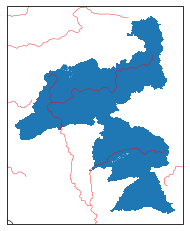

In [19]:
# # Save select CA basins
gdf_sel = pd.concat([outlet_drainage_ids[i] for i in ['AMF','SBB','YRS','FTO']])
fig = plt.figure()
ax = plt.subplot(111, projection=ccrs.PlateCarree())
gdf_sel.plot(ax=ax)
ax.add_feature(cfeature.RIVERS, edgecolor='r', lw=.4, zorder=1)
ax.add_feature(cfeature.COASTLINE, edgecolor='k', lw=.6)
# gdf_sel = gdf_sel.set_crs('EPSG:4326')
# outshp = '/glade/work/elkoukah/inputs/domain/shapefile/northern_sierras_amf-sbb-yrs-fto.shp'
# gdf_sel.to_file(outshp, layer='Catchment', driver="GPKG")
gdf_ca_sel = pd.concat([outlet_drainage_ids[i] for i in ['AMF','SBB','YRS','FTO']])
from shapely.geometry import Polygon
gdf_ca_sel = gpd.GeoDataFrame({'basin':['Northern Sierras'], 'geometry':[Polygon(gdf_ca_sel.unary_union.exterior.coords)]}, crs='EPSG:4326')

In [20]:
gdf0 = gpd.GeoDataFrame()
for key in outlet_drainage_ids.keys():
    geoms = outlet_drainage_ids[key]['geometry']
    # geoms.append(outlet_drainage_ids[key]['geometry'])
    tmp = gpd.GeoDataFrame({'gage_id':[key]*geoms.size, 'geometry':geoms})
    gdf0 = pd.concat([gdf0,tmp])
gdf0 = gdf0.set_crs(epsg=4326)
gdf0_crs = gdf0.to_crs(ccrs.PlateCarree())
gdf0_proj = gdf0.to_crs("EPSG:5070")

gdf0_proj['area'] = gdf0_proj.area

gauges_sorted_area = gdf0_proj.groupby('gage_id').sum().sort_values('area', ascending=False,).index.values

In [21]:
gdf1 = gpd.GeoDataFrame()
for gauge_id in gauges_sorted_area:
    tmp = gdf0_crs[gdf0_crs['gage_id']==gauge_id]
    gdf1 = pd.concat([gdf1,tmp])

In [22]:
gdf1_base = pd.merge(gdf1, metrics_southwest_base, left_on='gage_id', right_index=True)
gdf1_opt = pd.merge(gdf1, metrics_southwest_opt, left_on='gage_id', right_index=True)

In [23]:
# gdf1_base.to_file('out/gdf1_base.shp', layer='Catchment', driver="GPKG")
gdf1_opt.to_file('out/gdf1_opt.shp', layer='Catchment', driver="GPKG")

In [47]:
# Factors influencing model performance

In [48]:
tdelta = slice('1980-10-01','2019-09-30')

In [ ]:
def gen_polygon_mask(lats, lons, res, geom):
    gridcells = [Polygon(((x-res, y-res), 
                      (x-res, y+res), 
                      (x+res, y+res), 
                      (x+res,y-res), 
                      (x-res, y-res))) for x,y in zip(lons, lats)]
    ngrd = len(gridcells)
    mask = np.zeros((ngrd,), dtype=int)
    for ii in range(ngrd):
        mask[ii] = geom.intersects(gridcells[ii])
    return mask

import pickle
def ds_aave_polygon(ds,gdf):
    weightmap = xa.pixel_overlaps(ds,gdf)
    aggregated = xa.aggregate(ds, weightmap)
    ds_aave = aggregated.to_dataset()
    return ds_aave

In [ ]:
metric_gauges = metrics_southwest_base.index

cols = ['area','p_prism', 'p_conus', 'rnet', 'snow']
catch_attrs = pd.DataFrame(np.zeros((len(metric_gauges),len(cols))), columns=cols, index=metric_gauges)

In [28]:
# basin area

In [29]:
# area of KGE
# gdf1_opt_metric = gdf1_opt.to_crs('EPSG:5070')
gdf1_area = gdf1.to_crs('EPSG:5070')
gdf1_area['area'] = gdf1_area.area

In [31]:
mopt = metrics_southwest_opt
mbase = metrics_southwest_base
for gaugeid in metric_gauges:
    gA = gdf1_area[gdf1_area['gage_id']==gaugeid]['area'].sum()
    catch_attrs.loc[gaugeid, 'area'] = gA
    mopt.loc[gaugeid, 'area'] = gA
    mbase.loc[gaugeid, 'area'] = gA

In [32]:
# ma_base = metrics_southwest_base['mkge']>0.5
# ma_opt = metrics_southwest_opt['mkge']>0.5
# g_opt = metrics_southwest_opt['gage_id'][ma_opt].values
# g_base = metrics_southwest_base['gage_id'][ma_base].values

# A = gdf1_metric['area'].sum()
# gdf1_metric[gdf1_metric['gage_id'].isin(g_opt)]['area'].sum()/A
# # gdf1_metric[gdf1_metric['gage_id'].isin(g_base)]['area'].sum()/A

In [134]:
dict_geoms = {}
for gaugeid in metric_gauges:
    print(gaugeid, 'processing...')
    geomi = gdf0[gdf0['gage_id']==gaugeid].unary_union
    dict_geoms[gaugeid] = geomi

9034900 processing...
9035800 processing...
9035900 processing...
9047700 processing...
9065500 processing...
9066000 processing...
9066200 processing...
9066300 processing...
9081600 processing...
9107000 processing...
9210500 processing...
9223000 processing...
9306242 processing...
9312600 processing...
9352900 processing...
9378170 processing...
9378630 processing...
9386900 processing...
9404450 processing...
9430600 processing...
9447800 processing...
9480000 processing...
9484000 processing...
9484600 processing...
9492400 processing...
9494000 processing...
9497800 processing...
9497980 processing...
9505200 processing...
9505350 processing...
9505800 processing...
9508300 processing...
9510200 processing...
9512280 processing...
9513780 processing...
9429490 processing...
9427520 processing...
9426000 processing...
9423000 processing...
9421500 processing...
9415000 processing...
9402500 processing...
9402000 processing...
9382000 processing...
9380000 processing...
9379500 pr

In [33]:
# pickle.dump(dict_geoms, open('gauge_geoms.pkl', 'wb'))
dict_geoms = pickle.load(open('gauge_geoms.pkl', 'rb'))

In [37]:
list_geoms = list(dict_geoms.values())
gdf_gauges = gpd.GeoDataFrame({'geometry':list(list_geoms)}, index=dict_geoms.keys()).set_crs(epsg=4326)

In [58]:
# PRISM precip

In [ ]:
idir = '/glade/derecho/scratch/elkoukah/inputs/prism/postprocess/'
# tmean = xr.load_dataarray(idir+'tmean.nc')
ppt = xr.load_dataarray(idir+'ppt.nc')

ppt_mean = ppt.sel(time=tdelta).mean('time')

res = 0.04
dict_masks = {}
for gaugeid in metric_gauges:
    # print(gaugeid, 'processing...')
    # geomi = gdf0[gdf0['gage_id']==gaugeid].unary_union
    # gdfi = gpd.GeoDataFrame({'geometry':[geomi]}).set_crs(epsg=4326)
    gdfi = gdf_gauges.loc[[gaugeid]]
    minx, miny, maxx, maxy = gdfi.bounds.values[0]
    ppt_bb = ppt_mean.sel(lat=slice(miny-res,maxy+res), lon=slice(minx-res,maxx+res))
    # paave = ds_aave_polygon(ppt_bb, gdfi)
    # catch_attrs.loc[gaugeid, 'p_prism'] = paave['ppt'][0].data
    xx, yy = np.meshgrid(ppt_bb.lon, ppt_bb.lat)
    mask = gen_polygon_mask(yy.ravel(), xx.ravel(), res/2, gdfi['geometry'])
    dict_masks[gaugeid] = mask
    print(gaugeid, mask.sum(), 'processing...')
    paave = ppt_bb.stack(ngrd=('lat','lon')).sel(ngrd=(mask>0)).mean()
    catch_attrs.loc[gaugeid, 'p_prism'] = paave.data

In [218]:
# pickle.dump(dict_masks, open('gauge_masks_prism.pkl', 'wb'))
# dict_masks = pickle.load(open('gauge_geoms_prism.pkl', 'rb'))

In [ ]:
# model

In [46]:
catch_attrs = pd.read_csv('catch_attrs.csv', index_col=0)

In [85]:
archive_dir = '/glade/derecho/scratch/elkoukah/archive/'
casename = 'CA_conus404_newsurfdata_asmo.opt_002'
files = sorted(glob.glob(archive_dir+casename+'/lnd/hist/'+casename+'.clm2.h0.*.nc'))
data_vars = ['RAIN', 'SNOW', 'FSA', 'FIRA']
def preprocess(ds):
    return ds[data_vars]
h0 = xr.open_mfdataset(files, parallel=True, preprocess=preprocess)
h0['lon'] = h0.lon-360

h0_ann = h0.sel(time=tdelta).mean('time').compute()

ca_gauges = gdf_gauges.index[64:]

In [49]:
res = 0.04
ppt_mdl = (h0_ann['RAIN']+h0_ann['SNOW'])
rnet = h0_ann['FSA']-h0_ann['FIRA']
ds_mdl = xr.Dataset({'ppt':ppt_mdl, 'rnet':rnet})
for gaugeid in ca_gauges:
    print(gaugeid, 'processing...')
    # geomi = gdf0[gdf0['gage_id']==gaugeid].unary_union
    # gdfi = gpd.GeoDataFrame({'geometry':[geomi]}).set_crs(epsg=4326)
    gdfi = gdf_gauges.loc[[gaugeid]]
    minx, miny, maxx, maxy = gdfi.bounds.values[0]
    mdl_bb = ds_mdl.sel(lat=slice(miny-res,maxy+res), lon=slice(minx-res,maxx+res))
    mdlaave = ds_aave_polygon(mdl_bb, gdfi)
    pmean = mdlaave['ppt'][0].data
    rnetmean = mdlaave['rnet'][0].data
    catch_attrs.loc[gaugeid, 'p_conus'] = pmean*(24*60**2)*365
    catch_attrs.loc[gaugeid, 'rnet'] = rnetmean

AMF processing...
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
aggregating ppt...
aggregating rnet...
all variables aggregated to polygons!
AMN processing...
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
aggregating ppt...
aggregating rnet...
all variables aggregated to polygons!
ANM processing...
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
aggregating ppt...
aggregating rnet...
all variables aggregated to polygons!
ANT processing...
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
aggregating ppt...
aggregating rnet...
all va

In [86]:
# snowfall
res = 0.04
snow_mdl = h0_ann['SNOW']
for i,gaugeid in enumerate(ca_gauges):
    print(gaugeid, 'for', i, 'in', len(ca_gauges), mask.sum())
    gdfi = gdf_gauges.loc[[gaugeid]]
    minx, miny, maxx, maxy = gdfi.bounds.values[0]
    mdl_bb = snow_mdl.sel(lat=slice(miny-res,maxy+res), lon=slice(minx-res,maxx+res))
    # mdlaave = ds_aave_polygon(mdl_bb, gdfi)
    # snowmean = mdlaave['SNOW'][0].data
    xx,yy = np.meshgrid(mdl_bb.lon, mdl_bb.lat)
    mask = gen_polygon_mask(yy.ravel(), xx.ravel(), res/2, gdfi['geometry'])
    snowmean = mdl_bb.stack(ngrd=('lat','lon'))[mask>0].mean().data
    catch_attrs.loc[gaugeid, 'snow'] = snowmean*(24*60**2)*365

AMF for 0 in 59 880
AMN for 1 in 59 378
ANM for 2 in 59 96
ANT for 3 in 59 49
ASP for 4 in 59 26
ASS for 5 in 59 19
ASV for 6 in 59 61
CSN for 7 in 59 20
CYO for 8 in 59 124
DAV for 9 in 59 69
EFC for 10 in 59 20
ERS for 11 in 59 89
EWR for 12 in 59 615
FPL for 13 in 59 91
FPR for 14 in 59 411
FRD for 15 in 59 123
FTO for 16 in 59 39
FTP for 17 in 59 715
KGC for 18 in 59 37
KGF for 19 in 59 9
KLO for 20 in 59 299
KRB for 21 in 59 1852
KRI for 22 in 59 465
KRK for 23 in 59 397
KWT for 24 in 59 179
MBS for 25 in 59 122
MDP for 26 in 59 8
MKM for 27 in 59 75
MRC for 28 in 59 170
MSS for 29 in 59 237
NCD for 30 in 59 139
NPH for 31 in 59 86
OWL for 32 in 59 28
PSH for 33 in 59 108
RRH for 34 in 59 1187
SBB for 35 in 59 181
SCC for 36 in 59 1913
SCU for 37 in 59 92
SDT for 38 in 59 29
SIS for 39 in 59 102
SJF for 40 in 59 1466
SNS for 41 in 59 341
SRS for 42 in 59 214
SSP for 43 in 59 165
STB for 44 in 59 68
SVC for 45 in 59 90
SWH for 46 in 59 48
TLG for 47 in 59 27
TLM for 48 in 59 333
TL

In [38]:
archive_dir = '/glade/derecho/scratch/elkoukah/archive/'
casename = 'CR_conus404_asmo_newsurfdata_fanrootingdepth.002'
files = sorted(glob.glob(archive_dir+casename+'/lnd/hist/'+casename+'.clm2.h0.*.nc'))
data_vars = ['RAIN', 'SNOW', 'FSA', 'FIRA']
def preprocess(ds):
    return ds[data_vars]
h0 = xr.open_mfdataset(files, parallel=True, preprocess=preprocess)
h0['lon'] = h0.lon-360
h0_ann = h0.sel(time=tdelta).mean('time').compute()

In [40]:
import pickle
def ds_aave_polygon(ds,gdf):
    weightmap = xa.pixel_overlaps(ds,gdf,impl='dot_product')
    aggregated = xa.aggregate(ds,weightmap,impl='dot_product')
    ds_aave = aggregated.to_dataset()
    return ds_aave

In [ ]:
res = 0.04
ppt_mdl = (h0_ann['RAIN']+h0_ann['SNOW'])
rnet = h0_ann['FSA']-h0_ann['FIRA']
ds_mdl = xr.Dataset({'ppt':ppt_mdl, 'rnet':rnet})
for gaugeid in cr_gauges:
    print(gaugeid, 'processing...')
    # geomi = gdf0[gdf0['gage_id']==gaugeid].unary_union
    # gdfi = gpd.GeoDataFrame({'geometry':[geomi]}).set_crs(epsg=4326)
    gdfi = gdf_gauges.loc[[gaugeid]]
    minx, miny, maxx, maxy = gdfi.bounds.values[0]
    mdl_bb = ds_mdl.sel(lat=slice(miny-res,maxy+res), lon=slice(minx-res,maxx+res))
    mdlaave = ds_aave_polygon(mdl_bb, gdfi)
    pmean = mdlaave['ppt'][0].data
    rnetmean = mdlaave['rnet'][0].data
    catch_attrs.loc[gaugeid, 'p_conus'] = pmean*(24*60**2)*365
    catch_attrs.loc[gaugeid, 'rnet'] = rnetmean

9034900 processing...
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
aggregating ppt...
aggregating rnet...
all variables aggregated to polygons!
9035800 processing...
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
aggregating ppt...
aggregating rnet...
all variables aggregated to polygons!
9035900 processing...
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
aggregating ppt...
aggregating rnet...
all variables aggregated to polygons!
9047700 processing...
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
aggregating ppt...
aggregatin

In [72]:
# snowfall
res = 0.04
cr_gauges = gdf_gauges.index[:64]
snow_mdl = h0_ann['SNOW']
for i,gaugeid in enumerate(cr_gauges):
    print(gaugeid, 'for', i, 'in', len(cr_gauges), mask.sum())
    gdfi = gdf_gauges.loc[[gaugeid]]
    minx, miny, maxx, maxy = gdfi.bounds.values[0]
    mdl_bb = snow_mdl.sel(lat=slice(miny-res,maxy+res), lon=slice(minx-res,maxx+res))
    # mdlaave = ds_aave_polygon(mdl_bb, gdfi)
    # snowmean = mdlaave['SNOW'][0].data
    xx,yy = np.meshgrid(mdl_bb.lon, mdl_bb.lat)
    mask = gen_polygon_mask(yy.ravel(), xx.ravel(), res/2, gdfi['geometry'])
    snowmean = mdl_bb.stack(ngrd=('lat','lon'))[mask>0].mean().data
    catch_attrs.loc[gaugeid, 'snow'] = snowmean*(24*60**2)*365

9034900 for 0 in 64 6
9035800 for 1 in 64 6
9035900 for 2 in 64 7
9047700 for 3 in 64 11
9065500 for 4 in 64 7
9066000 for 5 in 64 7
9066200 for 6 in 64 7
9066300 for 7 in 64 4
9081600 for 8 in 64 4
9107000 for 9 in 64 51
9210500 for 10 in 64 36
9223000 for 11 in 64 44
9306242 for 12 in 64 37
9312600 for 13 in 64 15
9352900 for 14 in 64 24
9378170 for 15 in 64 25
9378630 for 16 in 64 6
9386900 for 17 in 64 5
9404450 for 18 in 64 23
9430600 for 19 in 64 24
9447800 for 20 in 64 24
9480000 for 21 in 64 71
9484000 for 22 in 64 28
9484600 for 23 in 64 15
9492400 for 24 in 64 106
9494000 for 25 in 64 19
9497800 for 26 in 64 131
9497980 for 27 in 64 67
9505200 for 28 in 64 51
9505350 for 29 in 64 36
9505800 for 30 in 64 40
9508300 for 31 in 64 61
9510200 for 32 in 64 15
9512280 for 33 in 64 44
9513780 for 34 in 64 25
9429490 for 35 in 64 24
9427520 for 36 in 64 31226
9426000 for 37 in 64 30166
9423000 for 38 in 64 827
9421500 for 39 in 64 28561
9415000 for 40 in 64 28404
9402500 for 41 in 64 

In [88]:
# catch_attrs.to_csv('catch_attrs_snow.csv')
# catch_attrs.to_csv('catch_attrs_2.csv')

# Plot

In [2]:
import matplotlib.gridspec as gridspec

In [4]:
shapefile = '/glade/work/elkoukah/inputs/domain/shapefile/WBD_14_HU2_Shape/WBDHU2.shp'
gdf_ucrb = gpd.read_file(shapefile)
gdf_ucrb_crs = gdf_ucrb.to_crs(ccrs.PlateCarree())

shapefile = '/glade/work/elkoukah/inputs/domain/shapefile/WBD_15_HU2_Shape/WBDHU2.shp'
gdf_lcrb = gpd.read_file(shapefile)
gdf_lcrb_crs = gdf_lcrb.to_crs(ccrs.PlateCarree())

shapefile = '/glade/work/elkoukah/inputs/domain/shapefile/WBD_18_HU2_Shape/WBDHU2.shp'
gdf_ca = gpd.read_file(shapefile)
gdf_ca_crs = gdf_ca.to_crs(ccrs.PlateCarree())

shapefile = '/glade/work/elkoukah/inputs/domain/shapefile/SWUS_studydomain_epsg4326.shp'
gdf_sw = gpd.read_file(shapefile)
gdf_sw_crs = gdf_sw.to_crs(ccrs.PlateCarree())

In [ ]:
gdf1_base = gpd.read_file('out/gdf1_base.shp')
gdf1_opt = gpd.read_file('out/gdf1_opt.shp')

In [5]:
comids_ca = pd.read_csv('/glade/work/elkoukah/inputs/obs/CDEC_Stations_COMID.csv')
comids_ca = comids_ca.set_index('STA')
comids_ca = comids_ca.drop('CLD')
cdec_stations = comids_ca.index.values

ca_opt_metrics = pd.read_csv('./out/metrics_opt_ca_camels_101980-092020.csv', index_col=0)
ca_opt_metrics = ca_opt_metrics.loc[ca_opt_metrics.index.isin(cdec_stations)] # drop camels from CA
cr_opt_metrics = pd.read_csv('./out/metrics_opt_cr_101980-092020.csv', index_col=0)
metrics_southwest_opt = pd.concat([cr_opt_metrics, ca_opt_metrics])

ca_base_metrics = pd.read_csv('./out/metrics_base_ca_camels_101980-092020.csv', index_col=0)
ca_base_metrics = ca_base_metrics.loc[ca_base_metrics.index.isin(cdec_stations)] # drop camels from CA
cr_base_metrics = pd.read_csv('./out/metrics_base_cr_101980-092019.csv', index_col=0)
metrics_southwest_base = pd.concat([cr_base_metrics, ca_base_metrics])

In [6]:
# station used in optimization
camels_ucrb = ['9034900', '9035800', '9035900', '9047700', '9065500', '9066000', '9066200', '9066300', '9081600', '9107000', '9210500', '9223000', '9306242', '9312600', '9352900', '9378170', '9378630']
reclamation_ucrb = ['9379500', '9355500', '9306500', '9260000', '9251000', '9234500', '9217000', '9211200', '9180000', '9152500', '9127800', '9124700', '9109000', '9095500', '9072500']
sac_ca = ['AMA', 'AMF', 'AMK', 'AMN', 'ANT', 'ASV', 'DAV', 'FPL', 
          'FPR', 'FRD', 'FTC', 'FTM', 'FTO', 'FTP', 'MSS', 'PLK',
          'PSH', 'SBB', 'SCU', 'SDT', 'SIS', 'SMU', 'SQS', 'SVC', 
          'YBG', 'YBJ', 'YBM', 'YBS', 'YCB', 'YRS']

ma1 = metrics_southwest_base.index.isin([float(i) for i in camels_ucrb])*False
ma2 = metrics_southwest_base.index.isin([float(i) for i in reclamation_ucrb])
ma3 = metrics_southwest_base.index.isin(sac_ca)
st_used_in_opt = (ma1+ma2+ma3)

In [7]:
metrics_southwest_opt[~st_used_in_opt].describe()

mkge         r2       beta      sigma       pbias        nse  \
count  82.000000  82.000000  82.000000  46.000000   82.000000  82.000000   
mean    0.410419   0.807862  -0.028765   0.860860   -6.037295   0.087150   
std     0.552488   0.176658   0.371389   0.517826   71.780677   1.502297   
min    -1.619567   0.035924  -0.737220   0.006283  -99.999998  -7.769424   
25%     0.061319   0.733627  -0.210077   0.477977  -47.455595   0.042613   
50%     0.616344   0.869639  -0.055568   0.974226   -7.477969   0.556396   
75%     0.824943   0.920696   0.020575   1.094666    2.854872   0.810961   
max     0.927521   0.968401   1.926944   2.172250  399.092042   0.901489   

          nse_wy     qsim_mean        lat         lon         alpha  
count  46.000000  8.500000e+01  85.000000   85.000000  3.600000e+01  
mean   -0.401118  5.878685e+01  37.000020 -114.402185  1.218462e+00  
std     3.408614  1.459454e+02   2.523430    5.452891  7.884518e-01  
min   -22.071864  1.756375e-07  31.355380 -124.099000  1.381385e-15  
25%    -0.176328  2.830675e-01  34.674740 -119.449000  8.788156e-01  
50%     0.240108  2.835804e+00  37.339430 -112.604380  9.966462e-01  
75%     0.696348  2.728551e+01  38.858308 -110.166770  1.555235e+00  
max     0.913066  5.670346e+02  42.110490 -105.906400  3.505946e+00

In [8]:
def kge_boxplot(ax, data, ylabel=r"KGE$^{''}$", xlabel_flag=True):
    st_used_in_opt = (ma1+ma2+ma3)
    st_used_in_opt = st_used_in_opt[~nan_mask]

    # all gages
    colors = ['#045a8d','#b30000']
    c = colors[0]
    boxprops = dict(linestyle='-', linewidth=1, color=c)
    capprops = boxprops
    whiskerprops = boxprops
    flierprops = dict(marker='o', markerfacecolor=c, markersize=2,markeredgecolor='none')
    medianprops = dict(linestyle='-', linewidth=1, color=c)
    bpref = ax.boxplot(data[:, 0][:, None], flierprops=flierprops, medianprops=medianprops, boxprops=boxprops,
                      whiskerprops=whiskerprops, capprops=capprops)
    
    c = colors[1]
    boxprops = dict(linestyle='-', linewidth=1, color=c)
    capprops = boxprops
    whiskerprops = boxprops
    flierprops = dict(marker='o', markerfacecolor=c, markersize=2,markeredgecolor='none')
    medianprops = dict(linestyle='-', linewidth=1, color=c)
    bpopt = ax.boxplot(data[:, 1][:, None], flierprops=flierprops, 
                      medianprops=medianprops, boxprops=boxprops,
                      whiskerprops=whiskerprops, capprops=capprops,
                      positions=[1.25])
    
    # optimized gages
    c = colors[0]
    boxprops = dict(linestyle='-', linewidth=1, color=c)
    capprops = boxprops
    whiskerprops = boxprops
    flierprops = dict(marker='o', markerfacecolor=c, markersize=2,markeredgecolor='none')
    medianprops = dict(linestyle='-', linewidth=1, color=c)
    bpref = ax.boxplot(data[:, 0][:, None][st_used_in_opt], flierprops=flierprops, medianprops=medianprops, boxprops=boxprops,
                      whiskerprops=whiskerprops, capprops=capprops,
                      positions=[1.75])
    c = colors[1]
    boxprops = dict(linestyle='-', linewidth=1, color=c)
    capprops = boxprops
    whiskerprops = boxprops
    flierprops = dict(marker='o', markerfacecolor=c, markersize=2,markeredgecolor='none')
    medianprops = dict(linestyle='-', linewidth=1, color=c)
    bpopt = ax.boxplot(data[:, 1][:, None][st_used_in_opt], flierprops=flierprops, 
                      medianprops=medianprops, boxprops=boxprops,
                      whiskerprops=whiskerprops, capprops=capprops,
                      positions=[2.])
    
    # other gages
    c = colors[0]
    boxprops = dict(linestyle='-', linewidth=1, color=c)
    capprops = boxprops
    whiskerprops = boxprops
    flierprops = dict(marker='o', markerfacecolor=c, markersize=2,markeredgecolor='none')
    medianprops = dict(linestyle='-', linewidth=1, color=c)
    bpref = ax.boxplot(data[:, 0][:, None][~st_used_in_opt], flierprops=flierprops, medianprops=medianprops, boxprops=boxprops,
                      whiskerprops=whiskerprops, capprops=capprops,
                      positions=[2.5])
    c = colors[1]
    boxprops = dict(linestyle='-', linewidth=1, color=c)
    capprops = boxprops
    whiskerprops = boxprops
    flierprops = dict(marker='o', markerfacecolor=c, markersize=2,markeredgecolor='none')
    medianprops = dict(linestyle='-', linewidth=1, color=c)
    bpopt = ax.boxplot(data[:, 1][:, None][~st_used_in_opt], flierprops=flierprops, 
                      medianprops=medianprops, boxprops=boxprops,
                      whiskerprops=whiskerprops, capprops=capprops,
                      positions=[2.75])
    
    # ax.axvspan(0.8,1.7, color='grey', alpha=.15, zorder=-1)
    # ax.axvspan(1.8,2.7, color='tab:blue', alpha=.15, zorder=-1)
    
    # ax.set_xticks([1.25,2.25])
    # ax.set_xticklabels(['Reference', 'Optimized'])
    ax.set_xticks([1.12,1.87,2.62])
    if xlabel_flag:
        ax.set_xticklabels(['All basins', 'Optimized', 'Out-of-sample'], rotation=90)
    else:
        ax.set_xticklabels(['', '', ''], rotation=90)
    
    ax.set_ylabel(ylabel)
    return bpref,bpopt

In [9]:
dict_sens_cr = pickle.load(open('dict_sens_cr.pkl', 'rb'))
dict_sens_ca = pickle.load(open('dict_sens_ca.pkl', 'rb'))

In [10]:
# SENSITIVITY inputs

temp = pd.read_csv('catch_attrs_2.csv')
catch_attrs = temp.iloc[:-64]
temp2 = temp.iloc[-64:].set_index('Unnamed: 0')
catch_attrs.iloc[:64, -1] = temp2.loc[[str(g) for g in metrics_southwest_base.index[:64]]]['rnet'].values
catch_attrs = catch_attrs.set_index('Unnamed: 0')
temp_snow = pd.read_csv('catch_attrs_snow.csv', index_col=0)
catch_attrs['snow'] = temp_snow['snow']

mopt = metrics_southwest_opt
mbase = metrics_southwest_base
str_index = [str(i) for i in mopt.index]
mopt.index = str_index
catch_attrs['rnet_mm'] = catch_attrs['rnet']/(2.5*10**6)*86400*365
catch_attrs['qmean'] = mopt['qsim_mean']
catch_attrs['qmean_mm'] = (catch_attrs['qmean']/catch_attrs['area'])*1000*365*24*3600
catch_attrs = catch_attrs.loc[str_index]

/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [11]:
slopes = {}
dxx, dyy0, dyy, dxx0, dkk = dict_sens_cr['dxx'], dict_sens_cr['dyy0'], dict_sens_cr['dyy'], dict_sens_cr['dxx0'], dict_sens_cr['dkk']
slope_mdl0, _ = np.linalg.lstsq(np.stack([dxx.data,np.ones(dxx.size)]).T, dyy0)[0]
slope_mdl, _ = np.linalg.lstsq(np.stack([dxx.data,np.ones(dxx.size)]).T, dyy)[0]
slope_obs, _ = np.linalg.lstsq(np.stack([dxx0.data,np.ones(dxx0.size)]).T, dkk)[0]
print('cr', slope_mdl0, slope_mdl, slope_obs, (slope_mdl0-slope_obs)/slope_obs, (slope_mdl-slope_obs)/slope_obs)
slopes['cr'] = (slope_mdl0, slope_mdl, slope_obs)

dxx, dyy0, dyy, dxx0, dkk = dict_sens_ca['dxx'], dict_sens_ca['dyy0'], dict_sens_ca['dyy'], dict_sens_ca['dxx0'], dict_sens_ca['dkk']
slope_mdl0, _ = np.linalg.lstsq(np.stack([dxx.data,np.ones(dxx.size)]).T, dyy0)[0]
slope_mdl, _ = np.linalg.lstsq(np.stack([dxx.data,np.ones(dxx.size)]).T, dyy)[0]
slope_obs, _ = np.linalg.lstsq(np.stack([dxx0.data,np.ones(dxx0.size)]).T, dkk)[0]
print('ca', slope_mdl0, slope_mdl, slope_obs, (slope_mdl0-slope_obs)/slope_obs, (slope_mdl-slope_obs)/slope_obs)
slopes['ca'] = (slope_mdl0, slope_mdl, slope_obs)

cr 0.9976963823169513 1.8320754444611005 1.5647443265441432 -0.3623901583203438 0.17084651682832963
ca 1.4328263561861803 1.7940567176747948 1.5245120722340417 -0.06014102329377025 0.17680715708978184


/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until
/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.
/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: `rcond` parameter will cha

In [12]:
cbar_ticks = {'mkge':np.arange(0., .91, .2),
              'sigma':np.array([0.5 , 0.75, 0.85, 1.15, 1.25, 1.5 ]),
              'beta':np.array([-0.5 , -0.25, -0.1, 0.1, 0.25, 0.5]),
              'r2':np.arange(0., .91, .2),}
labels = {'mkge':r"KGE$^{''}$",
          # 'mkge':r"modified Klingâ€“Gupta efficiency (KGE$^{''}$)",
          'r2':'$r$',
          'sigma':r'$\alpha$',
          'beta':r'$\beta$',
         }
extent = (-124.6, -105.6, 30.02, 43.46)
df1, df2 = metrics_southwest_base, metrics_southwest_opt
metric = 'mkge'
cmap = 'RdBu' #'PiYG'
norm = matplotlib.colors.BoundaryNorm(boundaries=cbar_ticks[metric], ncolors=256, extend='both')
ticks = cbar_ticks[metric]
label = labels[metric]

Text(-0.1, 0.275, 'd)')

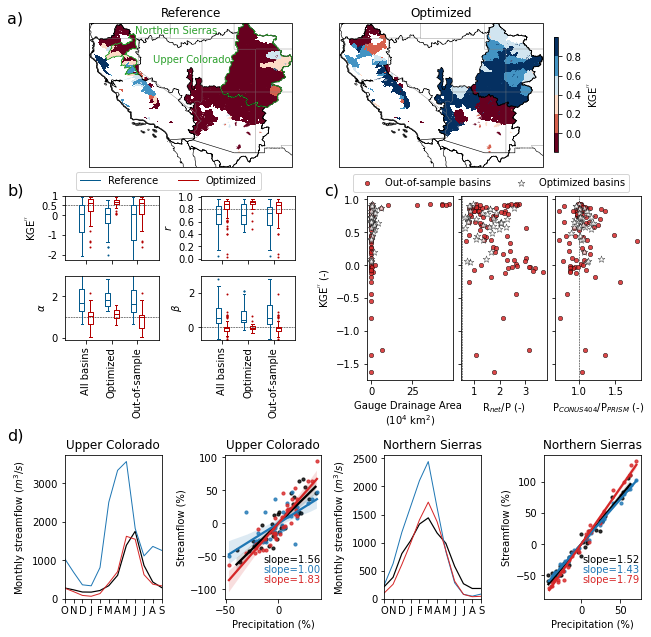

In [31]:
fig = plt.figure(figsize=(8,8))

# MAP of KGE''
gs1 = gridspec.GridSpec(1,2)
gs1.update(left=0.,right=1.,top=1.,bottom=.75,wspace=0.1,hspace=0.25)

plot_gdfs = [gdf1_base, gdf1_opt]
titles = ['Reference', 'Optimized']
axes = []
states_provinces = cfeature.NaturalEarthFeature(category='cultural',
                                                name='admin_1_states_provinces_lines',
                                                scale='50m',
                                                facecolor='none')
for i in range(2):
    ax = plt.subplot(gs1[0,i],projection=ccrs.PlateCarree())
    ax.set_title(titles[i])
    axes += [ax]
    ax.add_feature(states_provinces, edgecolor='grey', lw=.4)
    ax.add_feature(cfeature.BORDERS, edgecolor='k', lw=.6)
    # ax.add_feature(cfeature.LAKES, edgecolor='grey', lw=.1)
    ax.add_feature(cfeature.COASTLINE, edgecolor='k', lw=.6)
    gdf_ucrb_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
    gdf_lcrb_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
    gdf_ca_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
    gdf_sw_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
    ax.set_extent(extent)
    plot_gdfs[i].plot(ax=ax, column='mkge', cmap=cmap, norm=norm, edgecolor='None', lw=0, zorder=-1)
    if i==0:
        gdf_ca_sel.plot(ax=ax, edgecolor='tab:green', facecolor='None',lw=.6)
        gdf_ucrb_crs.plot(ax=ax, edgecolor='tab:green', facecolor='None',lw=.6)
        ax.annotate('Northern Sierras', (.225,.925), xycoords='axes fraction', ha='left', color='tab:green', fontsize=10)
        ax.annotate('Upper Colorado', (.695,.725), xycoords='axes fraction', ha='right', color='tab:green', fontsize=10)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cb = plt.colorbar(sm, ax=axes,location='right',aspect=30, shrink=.8, ticks=ticks, extendfrac='auto', extendrect=True, pad=0.02)
cb.set_label(label)

# BOXPLOT
gs2 = gridspec.GridSpec(2,2)
gs2.update(left=0.,right=.4,top=.7,bottom=.45,wspace=0.45,hspace=0.25)
# for i in range(4):
#     j = [(0,0),(0,1),(1,0),(1,1)]
#     ax = plt.subplot(gs2[j[i][0], j[i][1]])

data = np.stack([df1['mkge'].values, df2['mkge'].values]).T
nan_mask = np.isnan(data).any(axis=1)
data = data[~nan_mask]
ax = plt.subplot(gs2[0,0])
bpref,bpopt = kge_boxplot(ax, data, ylabel=r"KGE$^{''}$", xlabel_flag=False)
ax.axhline(0.5, color='k', ls='--', lw=.5, zorder=-2)
ax.set_ylim(-2.25,1)
ax.set_yticks([-2,-1,0,0.5,1]);
ax.set_yticklabels([-2,-1,0,0.5,1]);
ax.legend([bpref["boxes"][0], bpopt["boxes"][0]], ['Reference','Optimized'], loc='upper center', ncol=2, bbox_to_anchor=(1.1,1.45))


data = np.stack([df1['r2'].values, df2['r2'].values]).T
nan_mask = np.isnan(data).any(axis=1)
data = data[~nan_mask]
ax = plt.subplot(gs2[0,1])
kge_boxplot(ax, data, ylabel=r"$r$", xlabel_flag=False)
ax.axhline(0.8, color='k', ls='--', lw=.5, zorder=-2)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1]);

data = np.stack([df1['sigma'].values, df2['sigma'].values]).T
nan_mask = np.isnan(data).any(axis=1)
data = data[~nan_mask]
ax = plt.subplot(gs2[1,0])
kge_boxplot(ax, data, ylabel=r"$\alpha$")
ax.axhline(1, color='k', ls='--', lw=.5, zorder=-2)
# ax.set_yticks([0,0.2,0.4,0.6,0.8,1]);
ax.set_ylim(-0.1,3)

data = np.stack([df1['beta'].values, df2['beta'].values]).T
nan_mask = np.isnan(data).any(axis=1)
data = data[~nan_mask]
ax = plt.subplot(gs2[1,1])
kge_boxplot(ax, data, ylabel=r"$\beta$")
ax.axhline(0., color='k', ls='--', lw=.5, zorder=-2)
# ax.set_yticks([0,0.2,0.4,0.6,0.8,1]);
ax.set_ylim(-.7,3)

# SCATTERPLOT
gs3 = gridspec.GridSpec(1,3)
gs3.update(left=0.525,right=1.,top=.7,bottom=.38,wspace=0.1,hspace=0.25)
# for i in range(3):
#     ax = plt.subplot(gs3[0,i])
ax = plt.subplot(gs3[0,0])
x,y = catch_attrs['area']/10**6/10**4, mopt['mkge']
ax.scatter(x[~st_used_in_opt],y[~st_used_in_opt], color='tab:red', alpha=.85, edgecolor='k', lw=.5, s=20, label='Out-of-sample basins')
ax.scatter(x[st_used_in_opt],y[st_used_in_opt], marker='*', color='white', alpha=.75, edgecolor='k', lw=.5, s=50, label='Optimized basins')
ax.set_ylabel(r"KGE$^{''}$ (-)")
ax.set_xlabel('Gauge Drainage Area \n(10$^4$ km$^2$)')
ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(1.45,1.145))

ax = plt.subplot(gs3[0,1])
x,y = catch_attrs['rnet_mm']/catch_attrs['p_conus'], mopt['mkge']
# x,y = catch_attrs['snow']/catch_attrs['p_conus'], mopt['mkge']
ax.scatter(x[~st_used_in_opt],y[~st_used_in_opt], color='tab:red', alpha=.85, edgecolor='k', lw=.5, s=20)
ax.scatter(x[st_used_in_opt],y[st_used_in_opt], marker='*', color='white', alpha=.75, edgecolor='k', lw=.5, s=50)
# ax.scatter(catch_attrs['rnet_mm']/catch_attrs['p_conus'], mopt['mkge'], color='tab:red', alpha=.85, edgecolor='k', lw=.75, s=60)
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xlabel(r'R$_{net}$/P (-)')
ax.axvline(.5, color='k', ls='--', lw=.5, zorder=-2)

ax = plt.subplot(gs3[0,2])
x,y = catch_attrs['p_conus']/(catch_attrs['p_prism']*12), mopt['mkge']
ax.scatter(x[~st_used_in_opt],y[~st_used_in_opt], color='tab:red', alpha=.85, edgecolor='k', lw=.5, s=20, label='Other gauges')
ax.scatter(x[st_used_in_opt],y[st_used_in_opt], marker='*', color='white', alpha=.75, edgecolor='k', lw=.5, s=50, label='Optimized gauges')
# ax.scatter(catch_attrs['p_conus']/(catch_attrs['p_prism']*12), mopt['mkge'], color='tab:red', alpha=.85, edgecolor='k', lw=.75, s=60)
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xlabel(r'P$_{CONUS404}$/P$_{PRISM}$ (-)')
ax.axvline(1, color='k', ls='--', lw=.5, zorder=-2)


# HYDROGRAPH & SENSITIVITITY
gs4 = gridspec.GridSpec(1,4)
gs4.update(left=0.,right=1.,top=.25,bottom=.0,wspace=0.65,hspace=0.25)
## upper Colorado
ax = plt.subplot(gs4[0,0])
tdelta = slice('1981-10-01', '2019-09-30')
yy = dict_sens_cr['q_mdl'].sel(time=tdelta).groupby('time.month').mean()
yy0 = dict_sens_cr['q_mdl_base'].sel(time=tdelta).groupby('time.month').mean()
kk = dict_sens_cr['q_obs'].sel(time=tdelta).groupby('time.month').mean()
months = np.arange(12)
idx = np.append(months[9:],months[:9])
ax.plot(kk.data[idx], c='k', lw=1.2, label='Observed')
ax.plot(yy0.data[idx], c='tab:blue', lw=1, label='Reference')
ax.plot(yy.data[idx], c='tab:red', lw=1, label='Optimized')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks(months)
ax.set_xticklabels(['O','N','D', 'J','F','M','A','M','J','J','A','S',]);
ax.margins(x=0)
ax.set_ylim(0)
ax.set_ylabel('Monthly streamflow ($m^3/s$)')
ax.set_title('Upper Colorado')
# ax.legend(*ax.get_legend_handles_labels())


ax = plt.subplot(gs4[0,1])
sns.regplot(x=dict_sens_cr['dxx0'], y=dict_sens_cr['dkk'], ax=ax, color='k', truncate=True,
            scatter_kws={'s':10}, label='Observed');
sns.regplot(x=dict_sens_cr['dxx'], y=dict_sens_cr['dyy0'], ax=ax, color='tab:blue', truncate=True,
            scatter_kws={'s':10}, label='Reference');
sns.regplot(x=dict_sens_cr['dxx'], y=dict_sens_cr['dyy'], ax=ax, color='tab:red', truncate=True,
            scatter_kws={'s':10}, label='Optimized');
ax.set_ylabel(r'Streamflow (%)')
ax.set_xlabel(r'Precipitation (%)')
ax.set_title('Upper Colorado')
ax.tick_params(which='minor',length=3);   # dont show minor ticks; only labels
slope_mdl0, slope_mdl, slope_obs = slopes['cr']
ax.annotate(r"slope=%.2f"%slope_obs, (0.4,0.25), color='k', xycoords='axes fraction')
ax.annotate(r"slope=%.2f"%slope_mdl0, (0.4,0.18), color='tab:blue', xycoords='axes fraction')
ax.annotate(r"slope=%.2f"%slope_mdl, (0.4,0.11), color='tab:red', xycoords='axes fraction')

## California
ax = plt.subplot(gs4[0,2])
tdelta = slice('1981-10-01', '2019-09-30')
yy = dict_sens_ca['qopt'].sel(time=tdelta).groupby('time.month').mean()
yy0 = dict_sens_ca['qbase'].sel(time=tdelta).groupby('time.month').mean()
kk = dict_sens_ca['qobs'].sel(time=tdelta).groupby('time.month').mean()
months = np.arange(12)
idx = np.append(months[9:],months[:9])
ax.plot(kk.data[idx], c='k', lw=1.2, label='Observed discharge')
ax.plot(yy0.data[idx], c='tab:blue', lw=1, label='Simulated (reference)')
ax.plot(yy.data[idx], c='tab:red', lw=1, label='Simulated (optimized)')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks(months)
ax.set_xticklabels(['O','N','D', 'J','F','M','A','M','J','J','A','S',]);
ax.margins(x=0)
ax.set_ylim(0)
ax.set_ylabel('Monthly streamflow ($m^3/s$)')
ax.set_title('Northern Sierras')

ax = plt.subplot(gs4[0,3])
sns.regplot(x=dict_sens_ca['dxx0'], y=dict_sens_ca['dkk'], ax=ax, color='k', truncate=True,
            scatter_kws={'s':10}, label='Observed');
sns.regplot(x=dict_sens_ca['dxx'], y=dict_sens_ca['dyy0'], ax=ax, color='tab:blue', truncate=True,
            scatter_kws={'s':10}, label='Simulated (refrence)');
sns.regplot(x=dict_sens_ca['dxx'], y=dict_sens_ca['dyy'], ax=ax, color='tab:red', truncate=True,
            scatter_kws={'s':10}, label='Simulated (optimized)');
ax.set_ylabel(r'Streamflow (%)')
ax.set_xlabel(r'Precipitation (%)')
ax.set_title('Northern Sierras')
ax.tick_params(which='minor',length=3);   # dont show minor ticks; only labels
slope_mdl0, slope_mdl, slope_obs = slopes['ca']
ax.annotate(r"slope=%.2f"%slope_obs, (0.4,0.25), color='k', xycoords='axes fraction')
ax.annotate(r"slope=%.2f"%slope_mdl0, (0.4,0.18), color='tab:blue', xycoords='axes fraction')
ax.annotate(r"slope=%.2f"%slope_mdl, (0.4,0.11), color='tab:red', xycoords='axes fraction')

fig.text(-0.1, 1, 'a)', fontsize=16)
fig.text(-0.1, .7, 'b)', fontsize=16)
fig.text(.45, .7, 'c)', fontsize=16)
fig.text(-0.1, .275, 'd)', fontsize=16)

In [32]:
fig.savefig('figs/streamflow_sim_v02.png', dpi=300, bbox_inches='tight')